# Тестовое задание по графовым базам данных

# Содержание

[1. Задание](#Задание)  
[2. Загрузка данных](#Загрузка-данных)  
[3. Общие сведения о данных](#Общие-сведения-о-данных)  
[4. Загрузка данных из таблицы в графовую БД neo4j](#Загрузка-данных-из-таблицы-в-графовую-БД-neo4j)  
[5. Графовое представление в БД](#Графовое-представление-в-БД)  
[6. Несколько запросов на языке запросов к графовой БД](#Несколько-запросов-на-языке-запросов-к-графовой-БД)  
[7. Найти взаимосвязи визуально и с помощью алгоритмов](#Найти-взаимосвязи-визуально-и-с-помощью-алгоритмов)  
[7.1. Алгоритм PageRank](#Алгоритм-PageRank)  
[7.2. Степенная центральность](#Степенная-центральность)  
[7.3. Центральность по близости](#Центральность-по-близости)  
[7.4. Центральность по посредничеству](#Центральность-по-посредничеству)  
[8. Написать rest сервис на python к графовой БД](#Написать-rest-сервис-на-python-к-графовой-БД)  
[9. Выводы](#Выводы)

### Задание

1. Установить 2 графовые базы из списка DB-Engines Ranking  
- Предпочтительные - neo4j, nebula, arangodb
- Предпочтительный язык запросов cypher
2. Создать ipynb ноутбук в котором:
3. Считать данные из источника https://disk.yandex.ru/d/s6wWqd8Ol_5IvQ
4. Внести данные из таблицы в графовую БД
5. Построить графовое представление в БД, осуществить несколько запросов на языке запросов к графовой БД
6. Найти взаимосвязи визуально и с помощью алгоритмов (алгоритмы на ваше усмотрение)
7. Написать rest сервис на python к графовой БД в котором на вход поступает ФИО, на выходе graphml или json
8. Результаты представить на гитхаб и в виде кода + небольшой презентации
9. Прислать ссылку на решение и резюме в телеграм @frankshikhaliev
10. Также надо будет заполнить форму (Стажировка datascience в Mindset (основная форма))[https://docs.google.com/forms/d/e/1FAIpQLSfkavbuwPY20eQVS_dx7daQBGoBnDlGRtbfWzMKdi_tOFUkYg/viewform]

Срок выполнения задания - около 10 дней, если вы не успеваете можете взять больше времени

In [17]:
import pandas as pd
import requests
import urllib
import json

import matplotlib.pyplot as plt

from neo4j import GraphDatabase
import networkx as nx

In [103]:
#pip install neo4j

### Загрузка данных

In [32]:
folder_url = 'https://disk.yandex.ru/d/s6wWqd8Ol_5IvQ'
file_url = 'data_test.csv'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + \
        '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + \
        urllib.parse.quote(file_url)

In [3]:
r = requests.get(url) # запрос ссылки на скачивание
h = json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание

In [34]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/ArtemMaximov77/Test_GraphDB/main/data_test.csv', sep=';')
except FileNotFoundError:
    df = pd.read_csv(h, sep=';')

### Общие сведения о данных

In [35]:
df.head()

,id события,ФИО участника события 1,ФИО участника события 2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна


In [36]:
df.columns = ['id_event', 'person_event_1', 'person_event_2']

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_event        5000 non-null   int64 
 1   person_event_1  5000 non-null   object
 2   person_event_2  5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [38]:
df.nunique()

id_event          4985
person_event_1    4930
person_event_2    4994
dtype: int64

In [39]:
df.duplicated().sum()

0

In [40]:
df.duplicated(subset=['person_event_1', 'person_event_2']).sum()

0

### Загрузка данных из таблицы в графовую БД neo4j

Чтобы исключить дублирование существующего узла, вместо CREATE используется ключевое слово MERGE.  
MERGE для создания связей у существующих узлов.

In [114]:
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        if self.driver is not None:
            self.driver.close()

# Метод, который передает запрос в БД
    def query(self, query, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.driver.session(database=db) if db is not None else self.driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

In [142]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))
# Создание сессии
with driver.session() as session:  

    # Запись данных из DataFrame в Neo4j                            
    for index, row in df.iterrows():
        
        session.run('''MERGE (a:Person {first_name: $param11, second_name: $param10, patronymic: $param12})
                       MERGE (b:Person {first_name: $param21, second_name: $param20, patronymic: $param22})
                       MERGE (a)-[:id_event {event: $param0}]->(b)''', 
                    param0=row[0], 
                    param11=row[1].split()[1], param10=row[1].split()[0], param12=row[1].split()[2],
                    param21=row[2].split()[1], param20=row[2].split()[0], param22=row[2].split()[2])

### Графовое представление в БД

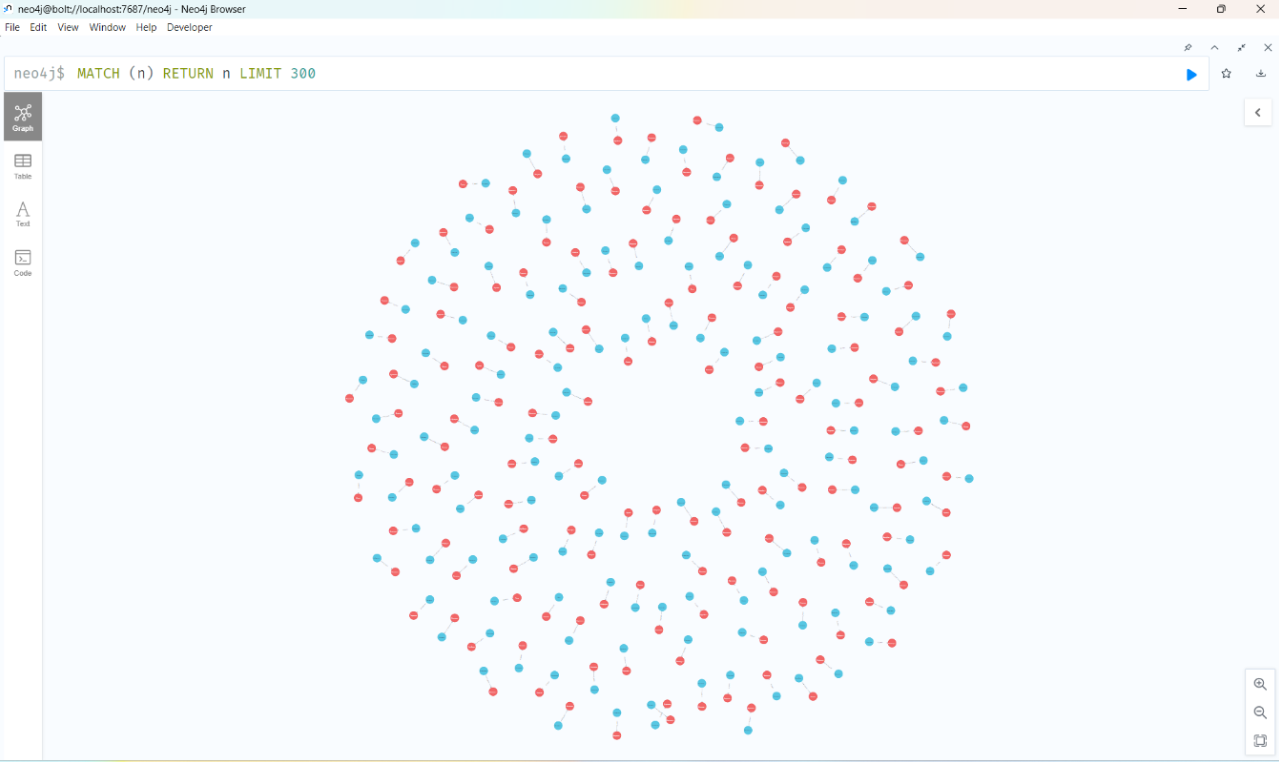

### Несколько запросов на языке запросов к графовой БД

Выведем первые 5 узлов.

In [115]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="12345678")
conn.query("MATCH (n) RETURN n LIMIT 5")

[<Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:0' labels=frozenset({'Person'}) properties={'patronymic': 'Владимировна', 'second_name': 'Галчевская', 'first_name': 'Карина'}>>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:1' labels=frozenset({'Person'}) properties={'patronymic': 'Семеновна', 'second_name': 'Белоновская', 'first_name': 'Анастасия'}>>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:2' labels=frozenset({'Person'}) properties={'patronymic': 'Романович', 'second_name': 'Офицеров', 'first_name': 'Олег'}>>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:3' labels=frozenset({'Person'}) properties={'patronymic': 'Валерьевич', 'second_name': 'Сапожник', 'first_name': 'Борис'}>>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:4' labels=frozenset({'Person'}) properties={'patronymic': 'Германовна', 'second_name': 'Жандарова', 'first_name': 'Лариса'}>>]

Выведем количество уникальных узлов.

In [143]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="12345678")
conn.query("MATCH (n) RETURN count(DISTINCT n)")

Failed to write data to connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))


[<Record count(DISTINCT n)=9899>]

Выведем общее количество связей, уникальное количество связей, уникальное количество ФИО события 1 и 2.

In [118]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="12345678")
conn.query('''MATCH (p1:Person_1)-[r:id_event]->(p2:Person_2)
              return count(r) AS total_record, 
                     count(DISTINCT r) AS uniq_id_event,
                     count(DISTINCT p1) AS uniq_person_event_1, 
                     count(DISTINCT p2) AS uniq_person_event_2''')

[<Record total_record=5000 uniq_id_event=5000 uniq_person_event_1=4930 uniq_person_event_2=4994>]

Выведем узлы с количеством связей более 1.

In [145]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="12345678")
temp = conn.query('''
            MATCH (n)--()
            WITH n, count(*) AS cnt_rel
            WHERE cnt_rel > 1
            RETURN n, cnt_rel
            ORDER BY cnt_rel DESC
           ''')
temp

[<Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:442' labels=frozenset({'Person'}) properties={'patronymic': 'Ивановна', 'second_name': 'Ахромеева', 'first_name': 'Алина'}> cnt_rel=50>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:685' labels=frozenset({'Person'}) properties={'patronymic': 'Глебовна', 'second_name': 'Башнина', 'first_name': 'Антонина'}> cnt_rel=14>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:904' labels=frozenset({'Person'}) properties={'patronymic': 'Алексеевна', 'second_name': 'Медведева', 'first_name': 'Дарья'}> cnt_rel=6>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:1327' labels=frozenset({'Person'}) properties={'patronymic': 'Даниловна', 'second_name': 'Зимнухова', 'first_name': 'Карина'}> cnt_rel=5>,
 <Record n=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:3602' labels=frozenset({'Person'}) properties={'patronymic': 'Ильдарович', 'second_name': 'Диомидов', 'first

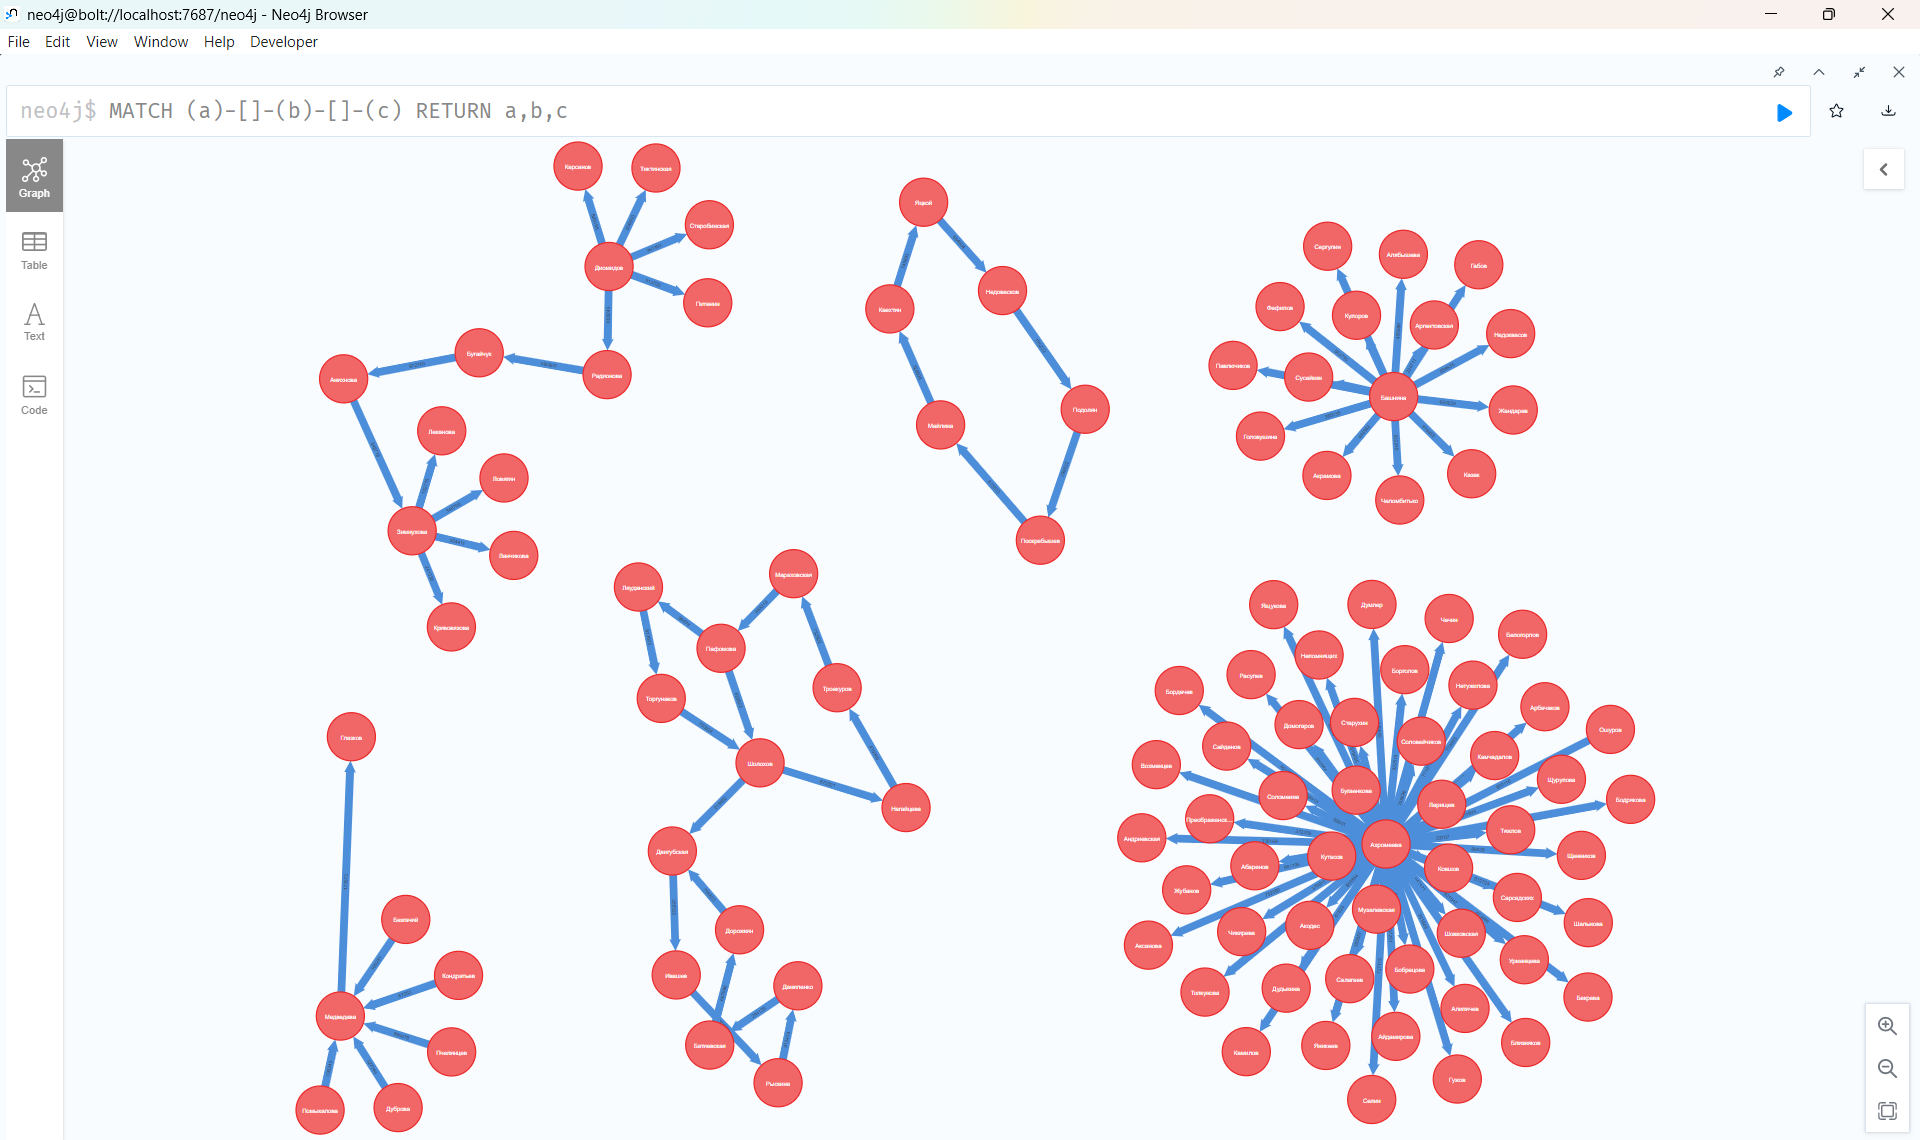

Выведем все связи участника Диомидов Игорь Ильдарович.

In [147]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="12345678")
temp = conn.query('''
            MATCH (p1: Person)-[]-(p2) 
            WHERE p1.patronymic='Ильдарович' AND p1.second_name='Диомидов' AND p1.first_name='Игорь'
            RETURN p1, p2
           ''')
temp

[<Record p1=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:3602' labels=frozenset({'Person'}) properties={'patronymic': 'Ильдарович', 'second_name': 'Диомидов', 'first_name': 'Игорь'}> p2=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:8989' labels=frozenset({'Person'}) properties={'patronymic': 'Григорьевна', 'second_name': 'Тиктинская', 'first_name': 'Галина'}>>,
 <Record p1=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:3602' labels=frozenset({'Person'}) properties={'patronymic': 'Ильдарович', 'second_name': 'Диомидов', 'first_name': 'Игорь'}> p2=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:8758' labels=frozenset({'Person'}) properties={'patronymic': 'Тимурович', 'second_name': 'Карсанов', 'first_name': 'Дамир'}>>,
 <Record p1=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:3602' labels=frozenset({'Person'}) properties={'patronymic': 'Ильдарович', 'second_name': 'Диомидов', 'first_name': 'Игорь'}> p2=<Node element_id='4:b9bb16cc-56d2

### Найти взаимосвязи визуально и с помощью алгоритмов

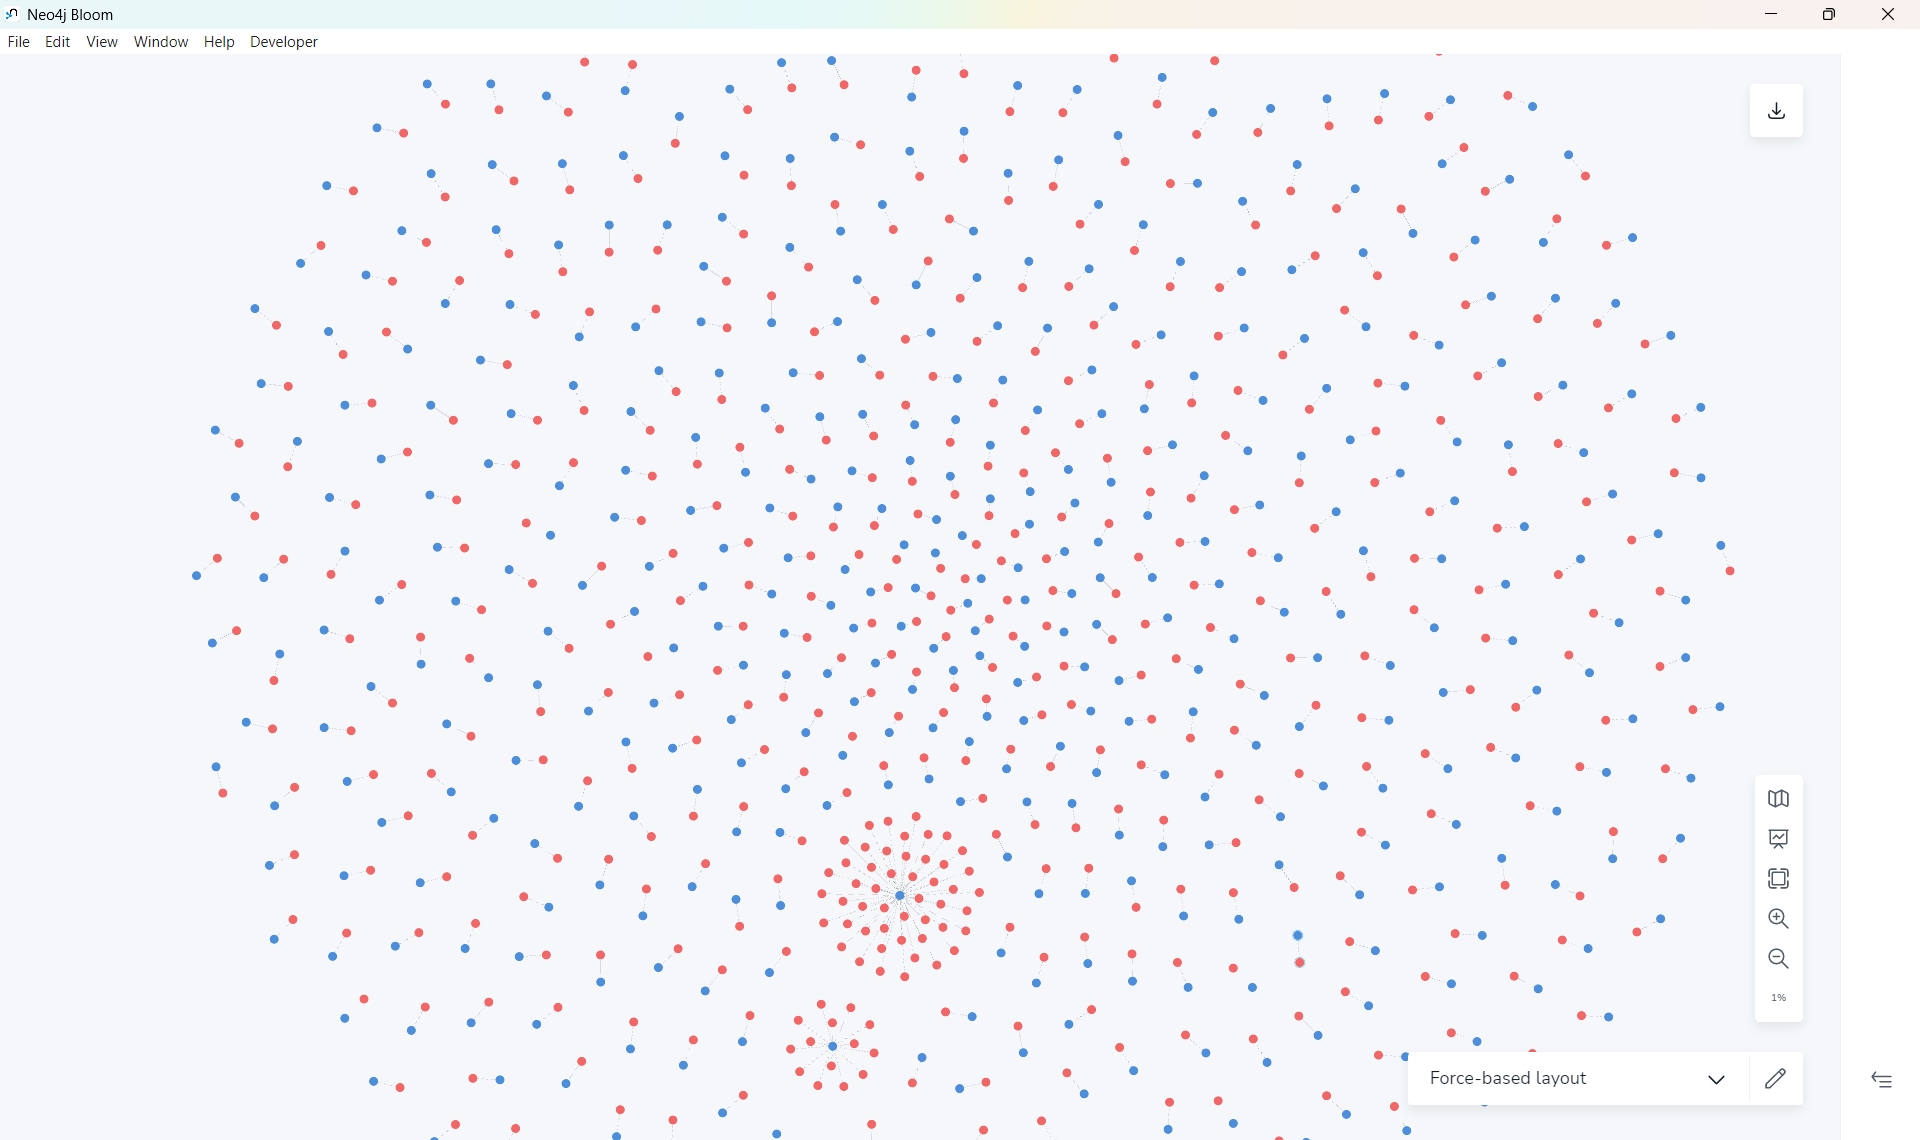

In [43]:
# Создаем пустой направленный граф
DG = nx.DiGraph()

In [44]:
# Заполняем направленный граф
DG = nx.from_pandas_edgelist(df, 'person_event_1', 'person_event_2', create_using=nx.DiGraph())

основные параметры графа: количество узлов, рёбер и среднее количество соседей у узлов в графе

In [45]:
print('Количество вершин: {}'.format(DG.number_of_nodes()))
print('Количество рёбер: {}'.format(DG.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(DG.number_of_edges() / 
                                                                       (DG.number_of_nodes()), 2)))

Количество вершин: 9899
Количество рёбер: 5000
Среднее количество соседей у узлов в графе: 0.51


Последний параметр отражает, насколько тесно связаны узлы между собой - очень слабая связь!

In [ ]:
# Визуализация графа
#from matplotlib.pyplot import figure
figure(figsize=(15, 10))
nx.draw_shell(DG, with_labels=False)

In [ ]:
figure(figsize=(15, 10))
nx.draw(DG, with_labels=False)

посмотрим, какой структурой обладает граф из нашего датасета:

In [46]:
if nx.is_directed(DG):
    if nx.is_weakly_connected(DG):
        print('Граф является направленным и состоит из одной компоненты слабой связности.')
    else:
        print('Граф является направленным и состоит из нескольких компонент.')
else:
    if nx.is_connected(DG):
        print('Граф является ненаправленным и связным.')
    else:
        print('Граф является ненаправленным и состоит из нескольких компонент.') 


Граф является направленным и состоит из нескольких компонент.


In [47]:
print('\nИсходный граф является сильно связным?', nx.is_strongly_connected(DG))
print('число сильно связных компонентов в исходном графе = ', nx.number_strongly_connected_components(DG))
print('Сильно связные компоненты = ', max(nx.strongly_connected_components(DG), key=len))

print('\nИсходный граф является слабо связным?', nx.is_weakly_connected(DG))
print('число слабосвязных компонентов в исходном графе = ', nx.number_weakly_connected_components(DG))
print('Слабо связные компоненты ', max(nx.weakly_connected_components(DG), key=len))


Исходный граф является сильно связным? False
число сильно связных компонентов в исходном графе =  9883
Сильно связные компоненты =  {'Троекуров Глеб Ефимович', 'Ляуданский Валентин Владиславович', 'Шолохов Игорь Робертович', 'Торгунаков Роман Кириллович', 'Пафомова Кира Вадимовна', 'Нагайцева Анжелика Яновна', 'Мараховская Дарья Романовна'}

Исходный граф является слабо связным? False
число слабосвязных компонентов в исходном графе =  4903
Слабо связные компоненты  {'Борголов Евгений Маратович', 'Бугаенкова Карина Аркадьевна', 'Жубанов Анатолий Иванович', 'Ахромеева Алина Ивановна', 'Ковшов Глеб Германович', 'Бордачев Никита Васильевич', 'Гужов Глеб Данилович', 'Алипичев Евгений Тимурович', 'Урманцева Евгения Олеговна', 'Старухин Дамир Маратович', 'Дудыкина Мария Романовна', 'Андриевская Марина Ринатовна', 'Бодрякова Евгения Яновна', 'Кутасов Константин Сергеевич', 'Соловейчиков Олег Павлович', 'Камчадалов Артем Ярославович', 'Соломеина Кристина Георгиевна', 'Арбачаков Филипп Андрееви

посмотрим на самые крупные компоненты слабой и сильной связности:

In [10]:
DG_weak = DG.subgraph(max(nx.weakly_connected_components(DG), key=len))
print('Количество вершин: {}'.format(DG_weak.number_of_nodes()))
print('Количество рёбер: {}'.format(DG_weak.number_of_edges()))
print('Среднее количество соседей у узла в графе: {}'.format(round(DG_weak.number_of_edges() / 
                                                                   (DG_weak.number_of_nodes()), 4)))

DG_strong = DG.subgraph(max(nx.strongly_connected_components(DG), key=len))
print('Количество вершин: {}'.format(DG_strong.number_of_nodes()))
print('Количество рёбер: {}'.format(DG_strong.number_of_edges()))
print('Среднее количество соседей у узла в графе: {}'.format(round(DG_strong.number_of_edges() / 
                                                                   (DG_strong.number_of_nodes()), 4)))

Количество вершин: 51
Количество рёбер: 50
Среднее количество соседей у узла в графе: 0.9804
Количество вершин: 7
Количество рёбер: 8
Среднее количество соседей у узла в графе: 1.1429


In [ ]:
plt.figure(figsize=(10, 5))
nx.draw(DG_weak, node_size=250)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
labels={}
for node in DG_strong.nodes():
    labels[node]=node
nx.draw(DG_strong, node_size=250, labels=labels)
plt.show()

In [112]:
DG_strong.nodes()

NodeView(('Торгунаков Роман Кириллович', 'Мараховская Дарья Романовна', 'Троекуров Глеб Ефимович', 'Нагайцева Анжелика Яновна', 'Шолохов Игорь Робертович', 'Пафомова Кира Вадимовна', 'Ляуданский Валентин Владиславович'))

In [38]:
leaderboard = {}
for x in DG.nodes:
    leaderboard[x] = len(DG[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)

In [39]:
df2.head()

,connections
Ахромеева Алина Ивановна,49
Башнина Антонина Глебовна,14
Диомидов Игорь Ильдарович,5
Зимнухова Карина Даниловна,4
Шолохов Игорь Робертович,2


#### Алгоритм PageRank

In [53]:
# Важность текущего узла по его связанным соседям
number_max = 10

pr = nx.pagerank(DG, alpha=0.9)
sorted_degree_centrality = sorted(pr, key=pr.get, reverse=True)
for i in sorted_degree_centrality[:number_max]:
    print('Node: ', i)
    print(f'Degree centrality: {pr[i]:2f}')

Node:  Двигубская Валентина Геннадьевна
Degree centrality: 0.000546
Node:  Ивашев Вячеслав Игоревич
Degree centrality: 0.000520
Node:  Рыскина Эльмира Ивановна
Degree centrality: 0.000487
Node:  Даниленко Владимир Семенович
Degree centrality: 0.000464
Node:  Батиевская Ангелина Романовна
Degree centrality: 0.000431
Node:  Шолохов Игорь Робертович
Degree centrality: 0.000419
Node:  Глазков Артур Петрович
Degree centrality: 0.000418
Node:  Дорожкин Анатолий Егорович
Degree centrality: 0.000401
Node:  Медведева Дарья Алексеевна
Degree centrality: 0.000380
Node:  Недовесков Владимир Иванович
Degree centrality: 0.000374


In [55]:
node = 'Двигубская Валентина Геннадьевна'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 1
Количество входящих связей: 2


In [56]:
node = 'Ивашев Вячеслав Игоревич'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 1
Количество входящих связей: 1


In [62]:
node = 'Рыскина Эльмира Ивановна'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 1
Количество входящих связей: 1


Наиболее влиятельными людьми являются (pagerank):  
- Двигубская Валентина Геннадьевна;
- Ивашев Вячеслав Игоревич;
- Рыскина Эльмира Ивановна.

#### Степенная центральность

In [64]:
# Посмотрим на узлы с максимальной центральностью по степени (наиболее влиятельные узлы)
number_max = 10

dc = nx.degree_centrality(DG)
sorted_degree_centrality = sorted(dc, key=bc.get, reverse=True)
for i in sorted_degree_centrality[:number_max]:
    print('Node: ', i)
    print(f'Degree centrality: {dc[i]:2f}')

Node:  Ахромеева Алина Ивановна
Degree centrality: 0.005052
Node:  Башнина Антонина Глебовна
Degree centrality: 0.001414
Node:  Медведева Дарья Алексеевна
Degree centrality: 0.000606
Node:  Зимнухова Карина Даниловна
Degree centrality: 0.000505
Node:  Диомидов Игорь Ильдарович
Degree centrality: 0.000505
Node:  Шолохов Игорь Робертович
Degree centrality: 0.000404
Node:  Пафомова Кира Вадимовна
Degree centrality: 0.000303
Node:  Двигубская Валентина Геннадьевна
Degree centrality: 0.000303
Node:  Ляуданский Валентин Владиславович
Degree centrality: 0.000202
Node:  Недовесков Владимир Иванович
Degree centrality: 0.000202


In [63]:
node = 'Ахромеева Алина Ивановна'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 49
Количество входящих связей: 1


In [64]:
node = 'Башнина Антонина Глебовна'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 14
Количество входящих связей: 0


In [65]:
node = 'Медведева Дарья Алексеевна'

print(f'Количество исходящих связей: {DG.out_degree(node)}')
print(f'Количество входящих связей: {DG.in_degree(node)}')

Количество исходящих связей: 1
Количество входящих связей: 5


Наиболее влиятельными людьми являются (degree_centrality):  
- Ахромеева Алина Ивановна;
- Башнина Антонина Глебовна;
- Медведева Дарья Алексеевна.

#### Центральность по близости

In [63]:
# узлы, которые могут эффективно распространять информацию через граф
number_max = 10

cc = nx.closeness_centrality(DG)
sorted_degree_centrality = sorted(cc, key=cc.get, reverse=True)
for i in sorted_degree_centrality[:number_max]:
    print('Node: ', i)
    print(f'Degree centrality: {cc[i]:2f}')

Node:  Медведева Дарья Алексеевна
Degree centrality: 0.000505
Node:  Двигубская Валентина Геннадьевна
Degree centrality: 0.000416
Node:  Ивашев Вячеслав Игоревич
Degree centrality: 0.000346
Node:  Глазков Артур Петрович
Degree centrality: 0.000331
Node:  Рыскина Эльмира Ивановна
Degree centrality: 0.000297
Node:  Шолохов Игорь Робертович
Degree centrality: 0.000280
Node:  Даниленко Владимир Семенович
Degree centrality: 0.000260
Node:  Нагайцева Анжелика Яновна
Degree centrality: 0.000242
Node:  Батиевская Ангелина Романовна
Degree centrality: 0.000231
Node:  Троекуров Глеб Ефимович
Degree centrality: 0.000214


Наиболее эффективное распространяют информацию: (closeness_centrality):  
- Медведева Дарья Алексеевна;
- Двигубская Валентина Геннадьевна;
- Ивашев Вячеслав Игоревич.

#### Центральность по посредничеству

In [48]:
# посредничество в передаче информации
number_max = 10

bc = nx.betweenness_centrality(DG)
sorted_degree_centrality = sorted(bc, key=bc.get, reverse=True)
for i in sorted_degree_centrality[:number_max]:
    print('Node: ', i)
    print(f'Degree centrality: {bc[i]:7f}')

Node:  Шолохов Игорь Робертович
Degree centrality: 0.000001
Node:  Ахромеева Алина Ивановна
Degree centrality: 0.000001
Node:  Двигубская Валентина Геннадьевна
Degree centrality: 0.000000
Node:  Ивашев Вячеслав Игоревич
Degree centrality: 0.000000
Node:  Пафомова Кира Вадимовна
Degree centrality: 0.000000
Node:  Рыскина Эльмира Ивановна
Degree centrality: 0.000000
Node:  Мараховская Дарья Романовна
Degree centrality: 0.000000
Node:  Даниленко Владимир Семенович
Degree centrality: 0.000000
Node:  Троекуров Глеб Ефимович
Degree centrality: 0.000000
Node:  Батиевская Ангелина Романовна
Degree centrality: 0.000000


Люди, которые служат мостом от одной части графа к другой: (betweenness_centrality):  
- Шолохов Игорь Робертович;
- Ахромеева Алина Ивановна;
- Двигубская Валентина Геннадьевна.

 
pagerank | degree_centrality | closeness_centrality | betweenness_centrality  
------------|------------- | --------- | ------------ 
**Двигубская Валентина Геннадьевна** | Ахромеева Алина Ивановна | Медведева Дарья Алексеевна | Шолохов Игорь Робертович  
Ивашев Вячеслав Игоревич | Башнина Антонина Глебовна | **Двигубская Валентина Геннадьевна** | Ахромеева Алина Ивановна  
Рыскина Эльмира Ивановна | Медведева Дарья Алексеевна | Ивашев Вячеслав Игоревич | **Двигубская Валентина Геннадьевна**

###  Написать rest сервис на python к графовой БД

In [24]:

class FioPerson:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def person_fio(self, message):
        with self.driver.session() as session:
            person_ = session.execute_write(self.return_greeting, message)
            #graphml = nx.GraphMLWriter(person_).serialize()
            print(person_)
            

    @staticmethod
    def return_greeting(tx, fio):
        result = tx.run("MATCH (p:Person {second_name :$fio}) RETURN p"
                        , fio=fio)
        return list(result)


if __name__ == "__main__":
    person = FioPerson("bolt://localhost:7687", "neo4j", "12345678")
    person.person_fio("Двигубская")
    person.close()

[<Record p=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:2205' labels=frozenset({'Person'}) properties={'patronymic': 'Геннадьевна', 'second_name': 'Двигубская', 'first_name': 'Валентина'}>>, <Record p=<Node element_id='4:b9bb16cc-56d2-43df-9631-9abb1f2f0b8d:9280' labels=frozenset({'Person'}) properties={'patronymic': 'Ивановна', 'second_name': 'Двигубская', 'first_name': 'Яна'}>>]


### **Выводы**

1. Анализ представленных данных показывает, что основная масса событий происходит между двумя участниками. Событие - это, возможно телефонный звонок. Также в данных имеются несколько явно выраженных сообществ.

2. Граф построенный на основе наших данных имеет 9899 вершин и 5000 ребер. Граф является направленным и состоит из нескольких компонент. 105 человек образуют 6 несвязанных сообществ.

3. Выявленны следующие типы компонент:
- Lollipop Graph. Граф леденца. В первом и втором случае информация передается от одного (или через цепочку посредников) человека другому, который в свою очередь раздает информацию многим людям. Во третьем случае информация от многих людей передается одному человеку, который в свою очередь передает информацию следующему человеку.

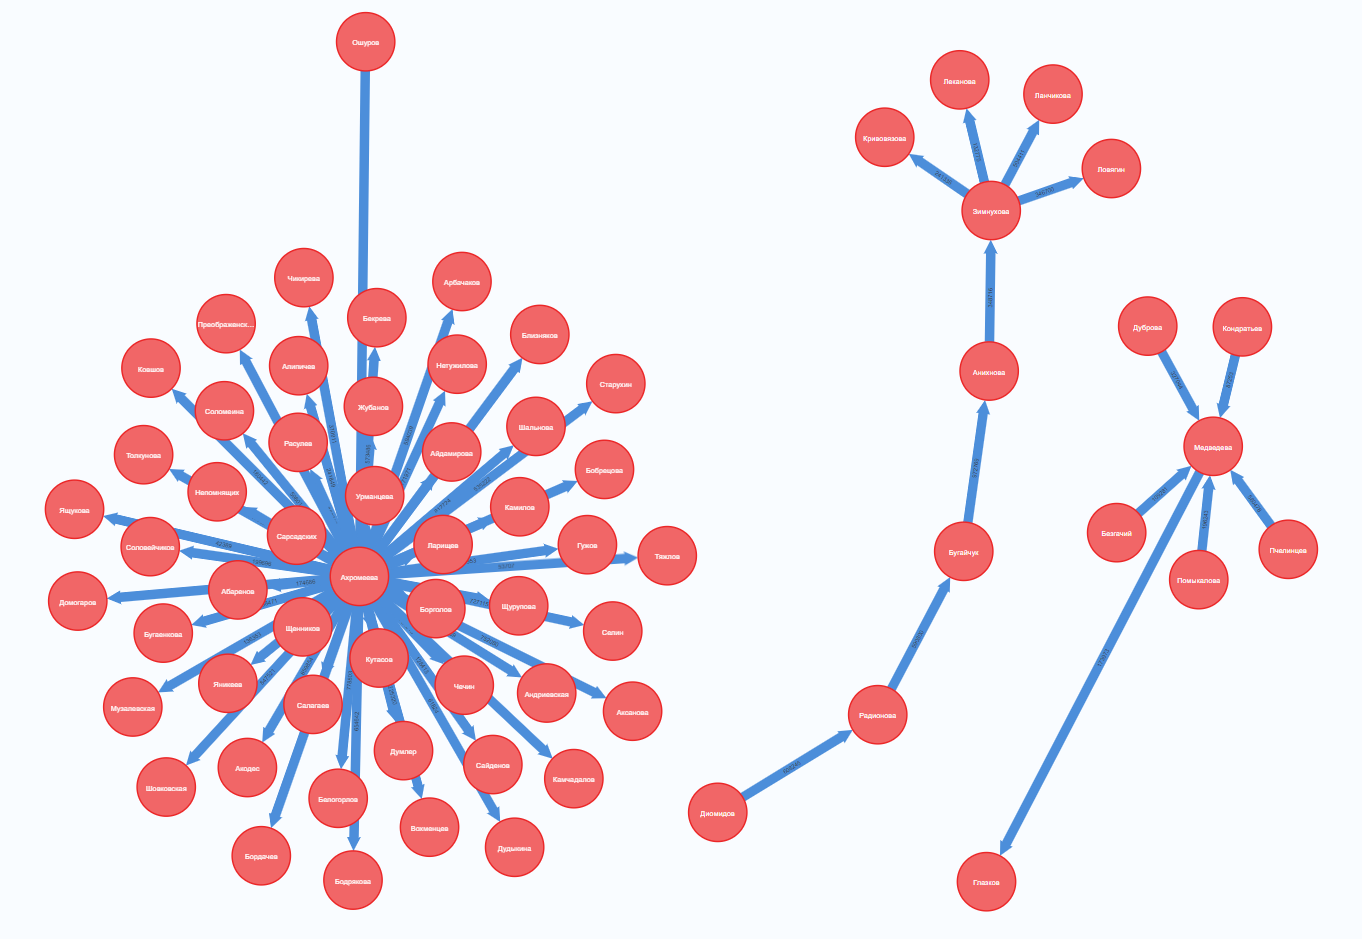

- Barbell Graph. Граф штанги. Здесь мы видим два небольших сообщества, которые имеют связь.

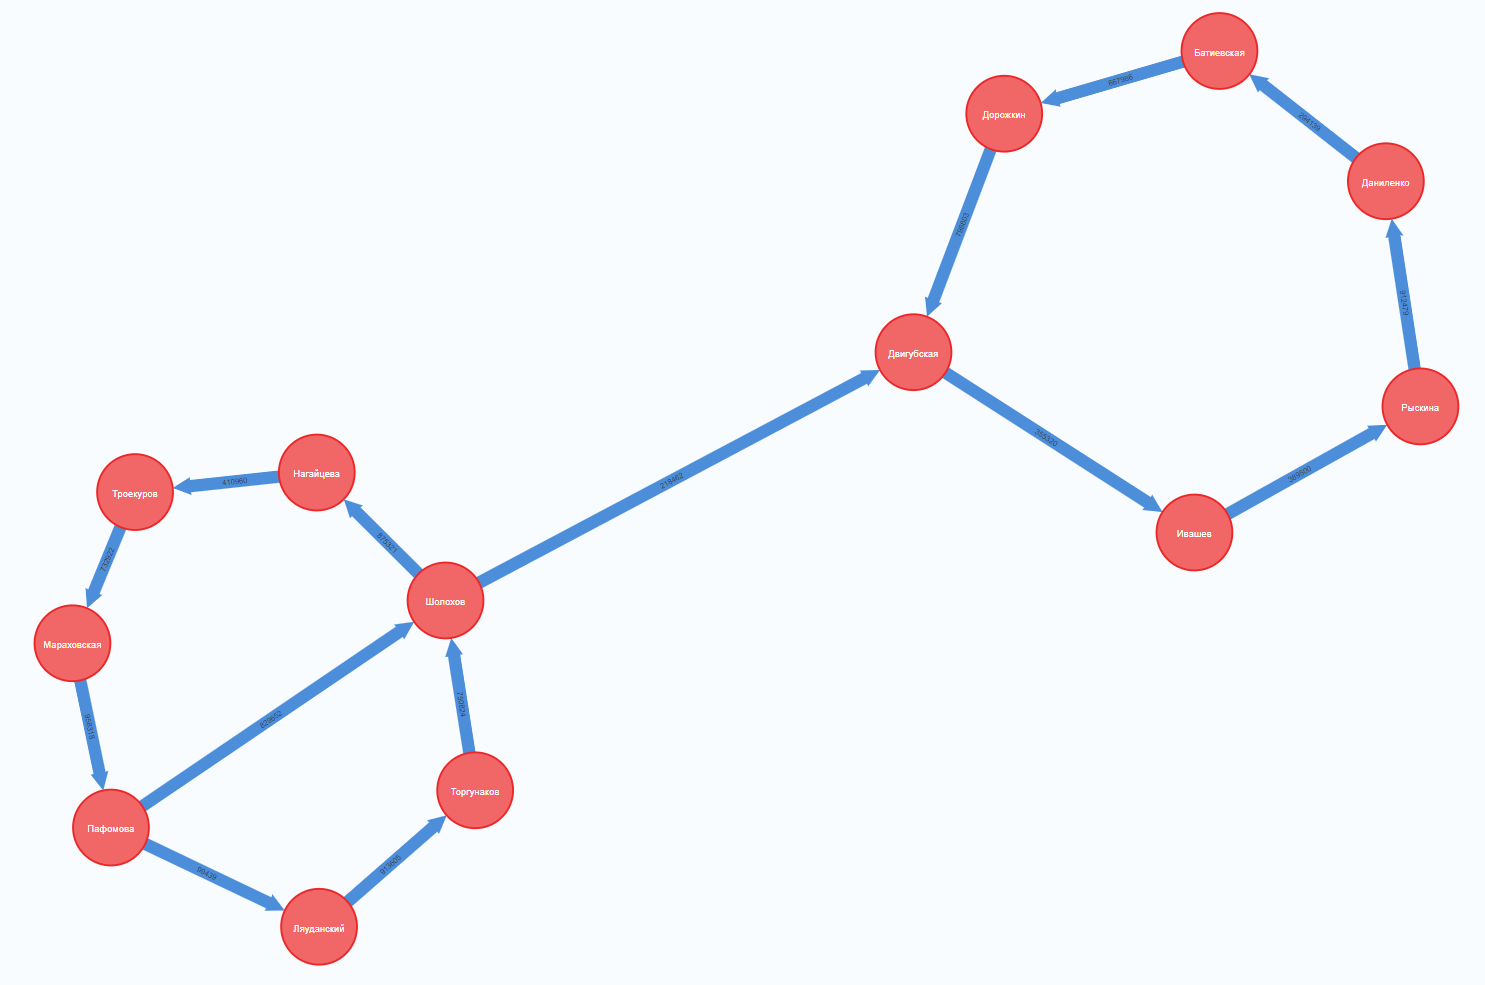

- Циклический граф.

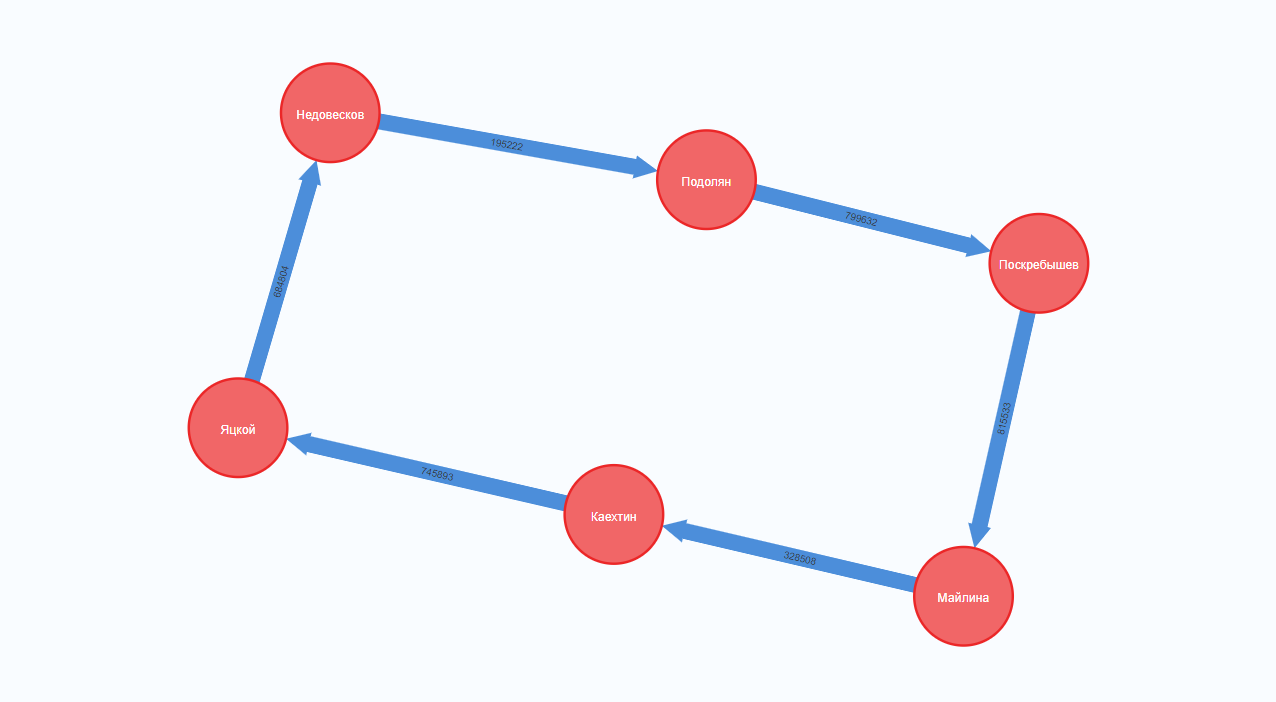

4. Роли отдельных узлов в графе и оценка уровня их влияния на сеть.

направленное влияние | степенная центральность | центральность по близости | центральность по посредничеству  
------------|------------- | --------- | ------------ 
pagerank | degree_centrality | closeness_centrality | betweenness_centrality  
**Двигубская Валентина Геннадьевна** | Ахромеева Алина Ивановна | Медведева Дарья Алексеевна | Шолохов Игорь Робертович  
Ивашев Вячеслав Игоревич | Башнина Антонина Глебовна | **Двигубская Валентина Геннадьевна** | Ахромеева Алина Ивановна  
Рыскина Эльмира Ивановна | Медведева Дарья Алексеевна | Ивашев Вячеслав Игоревич | **Двигубская Валентина Геннадьевна**  
узлы обширного влияния | самые влиятельные узлы | узлы распространяющие информацию быстрее всего | ключевые узлы по распространению информации